In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report as report
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from catboost import CatBoostClassifier, Pool
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, cross_val_score, RepeatedKFold, cross_val_predict
import tqdm
from imblearn.over_sampling import SMOTENC
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer

import pickle
import os

In [11]:
sns.set()
# plt.style.use('default')

## Import Data

In [2]:
with open('train.pkl', 'rb') as f:
    train = pickle.load(f)
    
with open('test.pkl', 'rb') as f:
    test = pickle.load(f)

In [3]:
train['Pembatalan_Sebulan_Terakhir'] = train['Pembatalan_Sebulan_Terakhir'].astype('float')
test['Pembatalan_Sebulan_Terakhir'] = test['Pembatalan_Sebulan_Terakhir'].astype('float')

In [4]:
del train['ID']
del test['ID']

del train['Encode_1']
del test['Encode_1']

In [5]:
def df_summary(df):
    res = pd.DataFrame()
    
    res['column'] = df.columns
    res['dtype'] = df.dtypes.values
    res['missing'] = df.isna().sum().values
    res['missing%'] = res['missing']/len(df)
    res['unique'] = df.nunique().values
    res['unique%'] = res['unique']/len(df)
    
    return res

In [6]:
print(train.shape)
df_summary(train)

(98749, 11)


,column,dtype,missing,missing%,unique,unique%
0,Jarak_Perjalanan,float64,21911,0.221886,10098,0.102259
1,Tipe_Kendaraan,object,21793,0.220691,10,0.000101
2,Pelanggan_Sejak_Bulan,float64,19519,0.197663,14,0.000142
3,Indeks_Gaya_Hidup,float64,27258,0.276033,44024,0.445817
4,Tipe_Tujuan,object,21692,0.219668,16,0.000162
5,Rating_Pelanggan,float64,21419,0.216903,3856,0.039048
6,Pembatalan_Sebulan_Terakhir,float64,18272,0.185035,10,0.000101
7,Encode_2,float64,17470,0.176913,53,0.000537
8,Encode_3,float64,21117,0.213845,91,0.000922
9,Gender,object,13828,0.140032,2,0.000020


In [7]:
print(test.shape)
df_summary(test)

(32916, 10)


,column,dtype,missing,missing%,unique,unique%
0,Jarak_Perjalanan,float64,6512,0.197837,8489,0.257899
1,Tipe_Kendaraan,object,7257,0.220470,10,0.000304
2,Pelanggan_Sejak_Bulan,float64,6368,0.193462,15,0.000456
3,Indeks_Gaya_Hidup,float64,5750,0.174687,21541,0.654423
4,Tipe_Tujuan,object,7184,0.218253,16,0.000486
5,Rating_Pelanggan,float64,7188,0.218374,3585,0.108914
6,Pembatalan_Sebulan_Terakhir,float64,7990,0.242739,8,0.000243
7,Encode_2,float64,10148,0.308300,42,0.001276
8,Encode_3,float64,7613,0.231286,85,0.002582
9,Gender,object,4608,0.139993,2,0.000061


In [8]:
train.head()

,Jarak_Perjalanan,Tipe_Kendaraan,Pelanggan_Sejak_Bulan,Indeks_Gaya_Hidup,Tipe_Tujuan,Rating_Pelanggan,Pembatalan_Sebulan_Terakhir,Encode_2,Encode_3,Gender,Target
0,55.06,C,NaN,NaN,A,NaN,0.0,49.0,NaN,Pria,2
1,61.82,C,NaN,2.77769,NaN,2.20250,1.0,53.0,75.0,Pria,2
2,58.24,B,10.0,3.17744,E,4.06625,NaN,NaN,62.0,Pria,2
3,32.26,A,4.0,2.69283,A,4.06625,0.0,53.0,74.0,NaN,2
4,27.46,C,0.0,NaN,H,1.35000,1.0,52.0,76.0,Wanita,3


## EDA

In [9]:
(train['Target'].value_counts()/len(train)).sort_index()

1    0.206220
2    0.430992
3    0.362788
Name: Target, dtype: float64

In [10]:
numeric_cols = train.select_dtypes(include=['float']).columns
numeric_cols

Index(['Jarak_Perjalanan', 'Pelanggan_Sejak_Bulan', 'Indeks_Gaya_Hidup',
       'Rating_Pelanggan', 'Pembatalan_Sebulan_Terakhir', 'Encode_2',
       'Encode_3'],
      dtype='object')

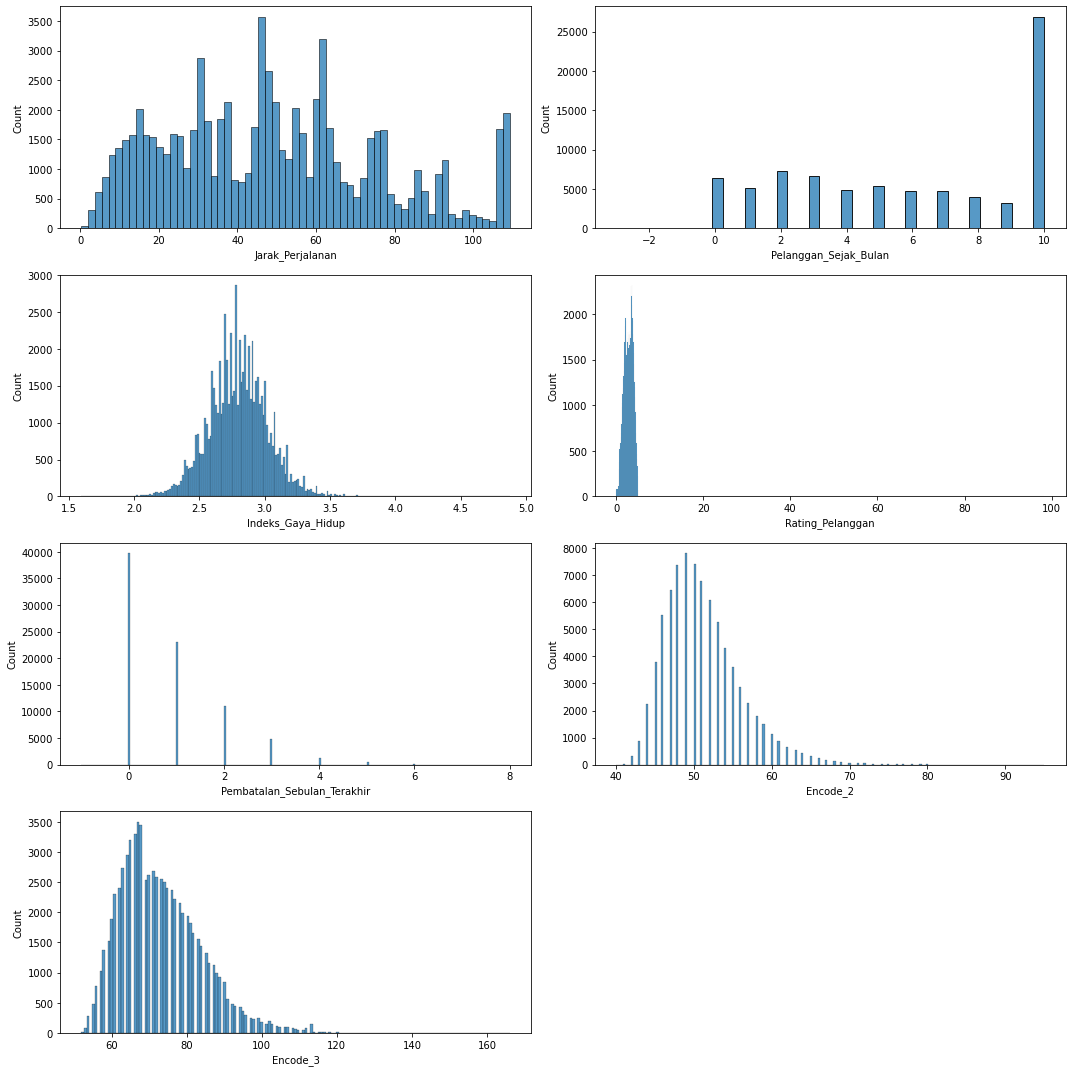

In [11]:
fig = plt.figure(figsize=(15,5*3))
spec = fig.add_gridspec(4,2)

for s,col in zip(spec,numeric_cols):
    ax = plt.subplot(s)
    sns.histplot(train[col], ax=ax)
    
plt.tight_layout()

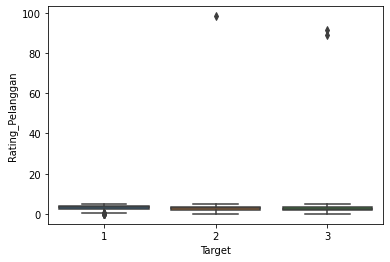

In [12]:
# Check boxplot for rating pelanggan
sns.boxplot(y=train['Rating_Pelanggan'], x=train['Target'])
plt.show()

In [13]:
# how many points are above 75 quantile
q75 = np.quantile(train['Rating_Pelanggan'].dropna(),.75)
sum(train['Rating_Pelanggan']>q75)

19312

In [14]:
cat_columns = list(train.select_dtypes(include='object').columns)

In [15]:
f, axes = plt.subplots(2,2,figsize=(15,5*2))
axes = axes.flatten()

for ax,col in zip(axes, cat_columns):
    sns.countplot(x=train[col].,ax=ax,hue=train['Target'],dodge=True)
    
plt.tight_layout()

SyntaxError: invalid syntax (<ipython-input-15-dd6b3d32eae2>, line 5)

In [ ]:
train['Pelanggan_Sejak_Bulan'].value_counts()

In [ ]:
train.columns

In [ ]:
# Train vs Test
f, axes = plt.subplots(7,2, figsize=(15,4*7))

for ax,col in zip(axes[:,0], numeric_cols):
    sns.histplot(train[col], ax=ax)

for ax,col in zip(axes[:,1], numeric_cols):
    sns.histplot(test[col], ax=ax)
    
plt.savefig('train v test.jpg', format='jpg', bbox_inches='tight')
plt.tight_layout()

In [16]:
cat_columns

['Tipe_Kendaraan', 'Tipe_Tujuan', 'Gender']

In [641]:
train['Tipe_Kendaraan'] = train['Tipe_Kendaraan'].fillna('nan').map(lambda x: x.upper() if x!='nan' else np.nan)
test['Tipe_Kendaraan'] = test['Tipe_Kendaraan'].fillna('nan').map(lambda x: x.upper() if x!='nan' else np.nan)

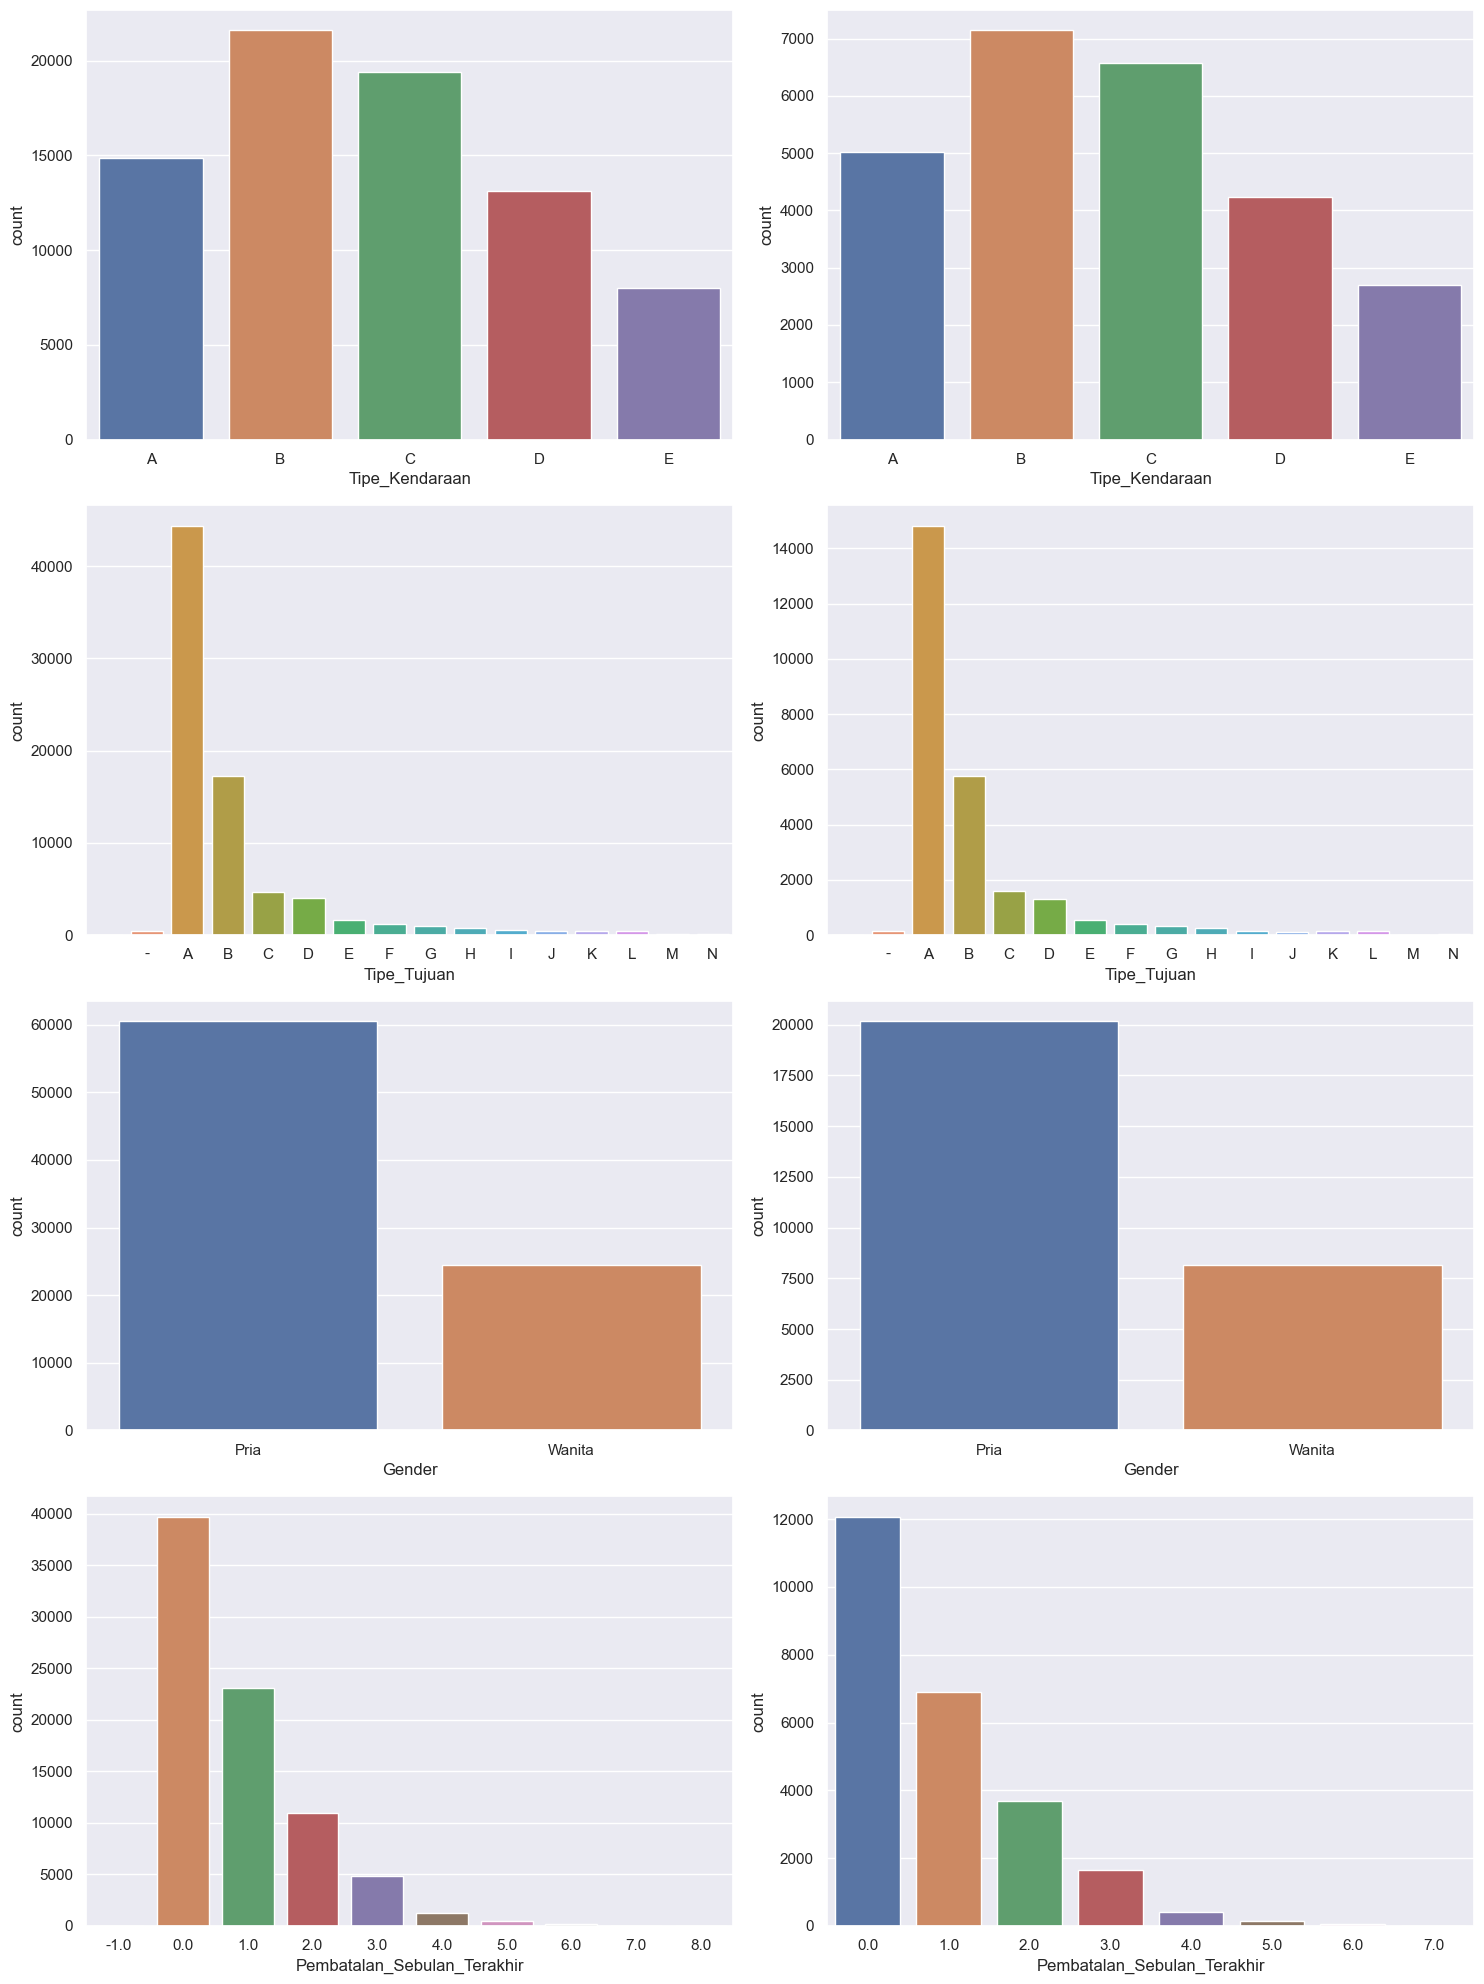

In [642]:
cat_columns = cat_columns + ['Pembatalan_Sebulan_Terakhir','Pelanggan_Sejak_Bulan']

f, axes = plt.subplots(4,2,figsize=(15,5*4))

for ax,col in zip(axes[:,0],cat_columns):
    sns.countplot(x=train[col].sort_values(), ax=ax)
    
for ax,col in zip(axes[:,1],cat_columns):
    sns.countplot(x=test[col].sort_values(), ax=ax)
    

plt.tight_layout()
plt.savefig('categorical plot.jpg', format='jpg', bbox_inches='tight')

Text(0.5, 1.0, 'Target Proportion')

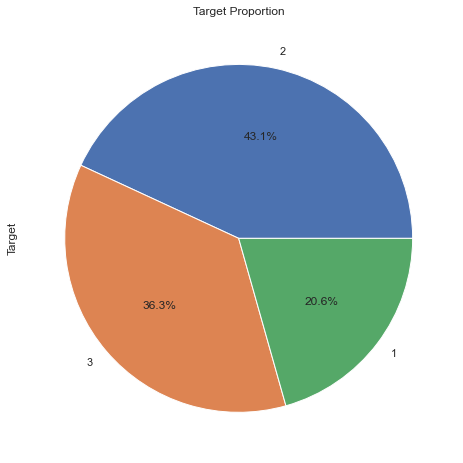

In [21]:
# Target Value Distribution
fig, ax1 = plt.subplots(1, 1, figsize=(16,8))
train['Target'].value_counts(normalize=True).plot(ax=ax1, kind='pie',autopct="%.1f%%")
plt.title('Target Proportion')

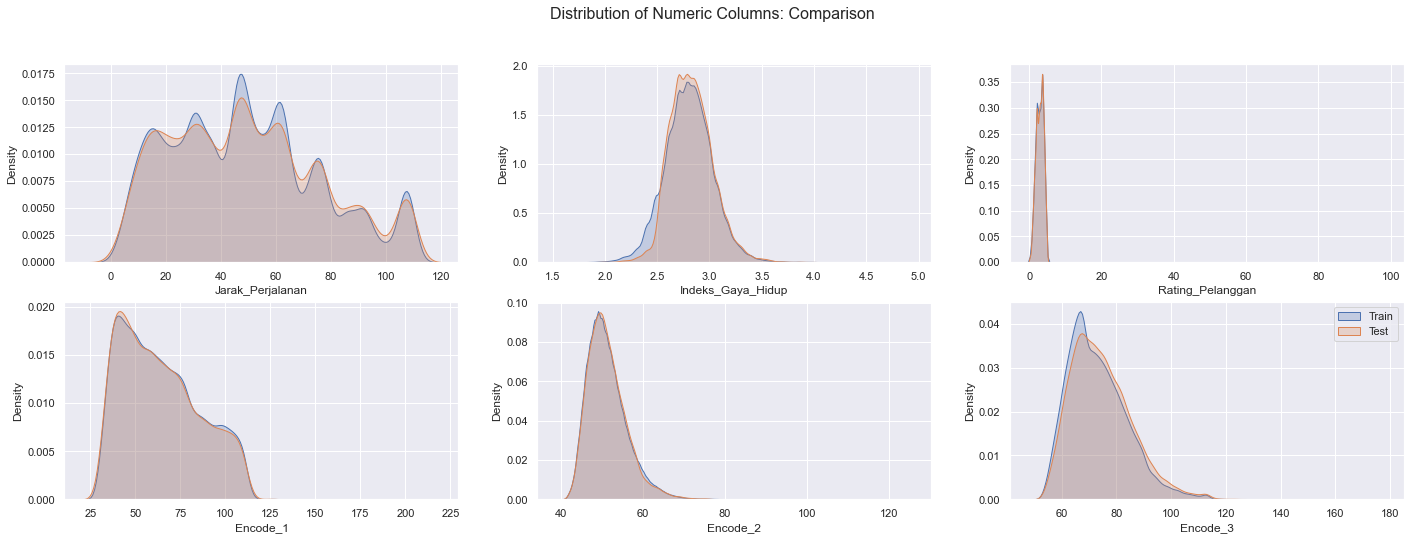

In [24]:
# Distribution of Numeric Columns By Target Other Than Pelanggan_Sejak_Bulan & Pembatalan_Sebulan_Terakhir
fig, ((ax1,ax3,ax4),(ax6,ax7,ax8)) = plt.subplots(2,3,figsize=(24,8))

fig.suptitle('Distribution of Numeric Columns: Comparison', fontsize=16)

sns.kdeplot(ax=ax1, x='Jarak_Perjalanan', data=train, shade=True, label='Train')
sns.kdeplot(ax=ax3, x='Indeks_Gaya_Hidup', data=train, shade=True, label='Train')
sns.kdeplot(ax=ax4, x='Rating_Pelanggan', data=train, shade=True, label='Train')
sns.kdeplot(ax=ax6, x='Encode_1', data=train, shade=True, label='Train')
sns.kdeplot(ax=ax7, x='Encode_2', data=train, shade=True, label='Train')
sns.kdeplot(ax=ax8, x='Encode_3', data=train, shade=True, label='Train')

sns.kdeplot(ax=ax1, x='Jarak_Perjalanan', data=test, shade=True, label='Test')
sns.kdeplot(ax=ax3, x='Indeks_Gaya_Hidup', data=test, shade=True, label='Test')
sns.kdeplot(ax=ax4, x='Rating_Pelanggan', data=test, shade=True, label='Test')
sns.kdeplot(ax=ax6, x='Encode_1', data=test, shade=True, label='Test')
sns.kdeplot(ax=ax7, x='Encode_2', data=test, shade=True, label='Test')
sns.kdeplot(ax=ax8, x='Encode_3', data=test, shade=True, label='Test')

plt.legend()

<AxesSubplot:xlabel='Encode_3', ylabel='Density'>

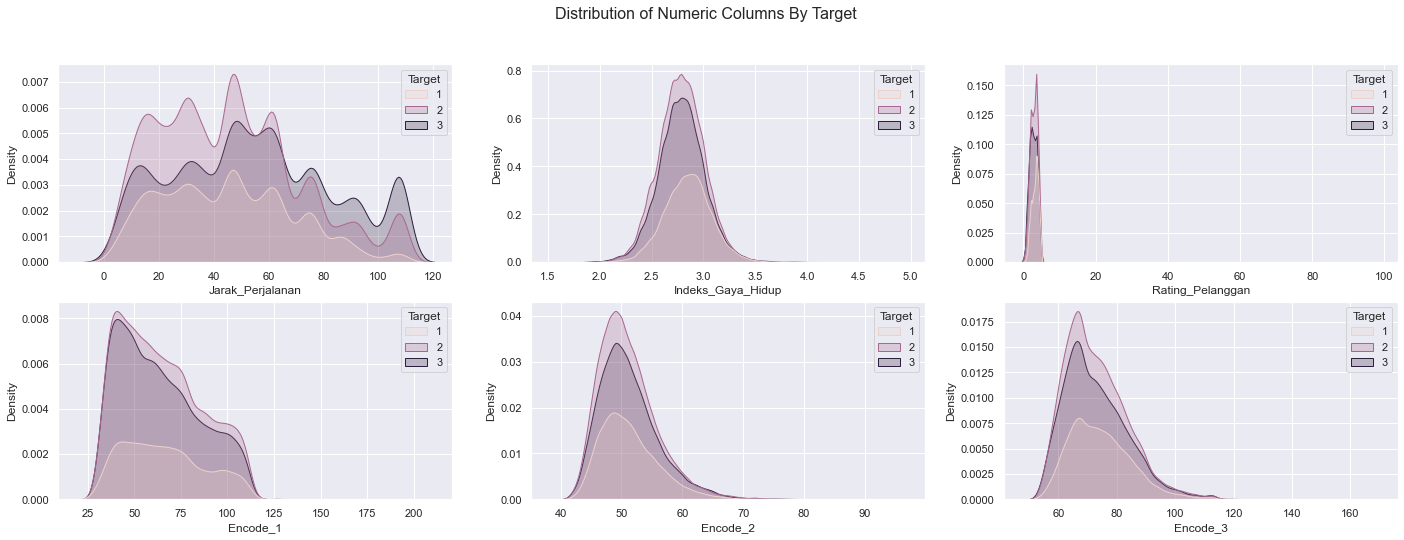

In [25]:
# Distribution of Numeric Columns By Target Other Than Pelanggan_Sejak_Bulan & Pembatalan_Sebulan_Terakhir
fig, ((ax1,ax3,ax4),(ax6,ax7,ax8)) = plt.subplots(2,3,figsize=(24,8))

fig.suptitle('Distribution of Numeric Columns By Target', fontsize=16)

sns.kdeplot(ax=ax1, x='Jarak_Perjalanan', hue='Target', data=train, shade=True)
sns.kdeplot(ax=ax3, x='Indeks_Gaya_Hidup', hue='Target', data=train, shade=True)
sns.kdeplot(ax=ax4, x='Rating_Pelanggan', hue='Target', data=train, shade=True)
sns.kdeplot(ax=ax6, x='Encode_1', hue='Target', data=train, shade=True)
sns.kdeplot(ax=ax7, x='Encode_2', hue='Target', data=train, shade=True)
sns.kdeplot(ax=ax8, x='Encode_3', hue='Target', data=train, shade=True)

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Tipe_Kendaraan', ylabel='count'>

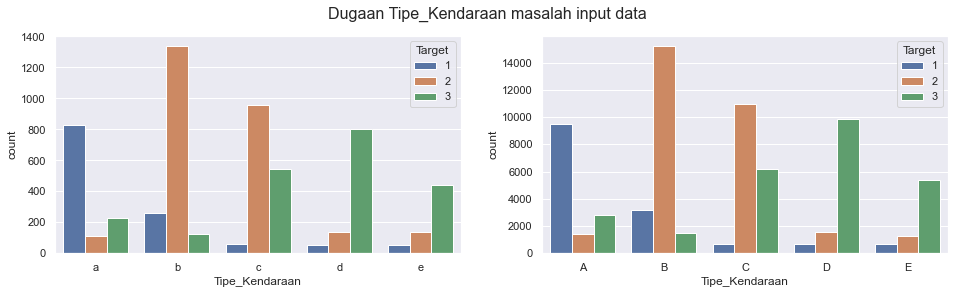

In [26]:
# Dugaan Tipe_Kendaraan masalah input data
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))

fig.suptitle('Dugaan Tipe_Kendaraan masalah input data', fontsize=16)

sns.countplot(train[train['Tipe_Kendaraan'].isin(['a','b','c','d','e'])]['Tipe_Kendaraan'], hue='Target', data=train, ax=ax1, order=['a','b','c','d','e'])
sns.countplot(train[~train['Tipe_Kendaraan'].isin(['a','b','c','d','e'])]['Tipe_Kendaraan'], hue='Target', data=train, ax=ax2, order=['A','B','C','D','E'])

Text(0, 0.5, 'Test Count')

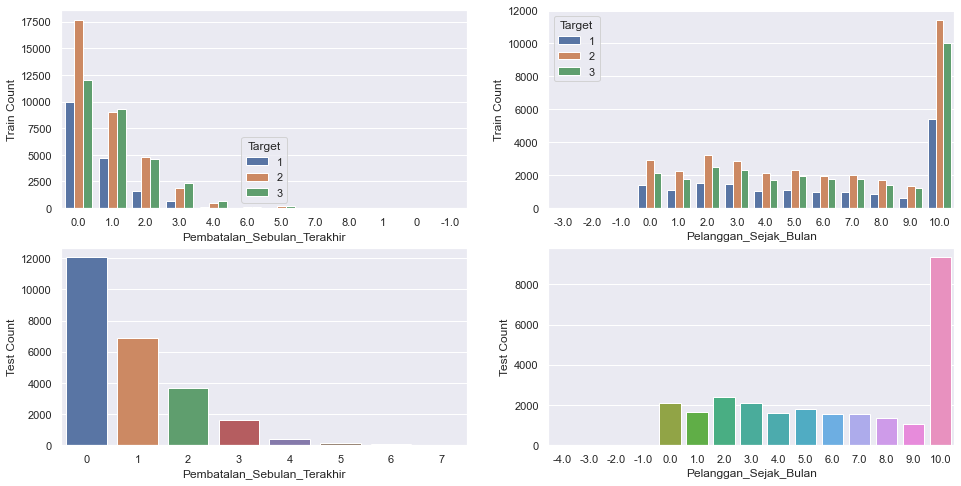

In [27]:
# Distribution of Pelanggan_Sejak_Bulan & Pembatalan_Sebulan_Terakhir Columns By Target
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(16,8))

sns.countplot(ax=ax1, x='Pembatalan_Sebulan_Terakhir', hue='Target', data=train)
sns.countplot(ax=ax2, x='Pelanggan_Sejak_Bulan', hue='Target', data=train)

sns.countplot(ax=ax3, x='Pembatalan_Sebulan_Terakhir', data=test, order=[0,1,2,3,4,5,6,7])
sns.countplot(ax=ax4, x='Pelanggan_Sejak_Bulan', data=test)

ax1.set_ylabel('Train Count')
ax2.set_ylabel('Train Count')
ax3.set_ylabel('Test Count')
ax4.set_ylabel('Test Count')

Text(0, 0.5, 'Percentage Missing')

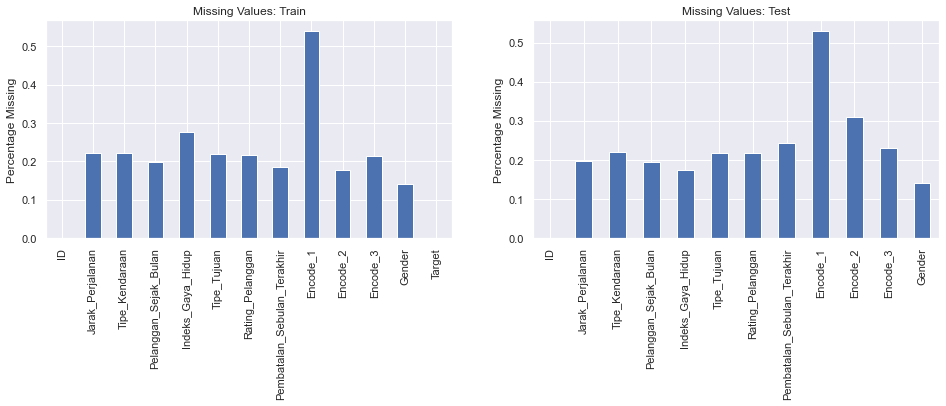

In [28]:
# Missing Values
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))

sns.color_palette("mako", as_cmap=True)
(train.isna().sum()/train.shape[0]).plot(kind='bar', ax=ax1)
ax1.set_title('Missing Values: Train')
ax1.set_ylabel('Percentage Missing')

(test.isna().sum()/test.shape[0]).plot(kind='bar', ax=ax2)
ax2.set_title('Missing Values: Test')
ax2.set_ylabel('Percentage Missing')

Text(0.5, 1.0, 'Heatmap')

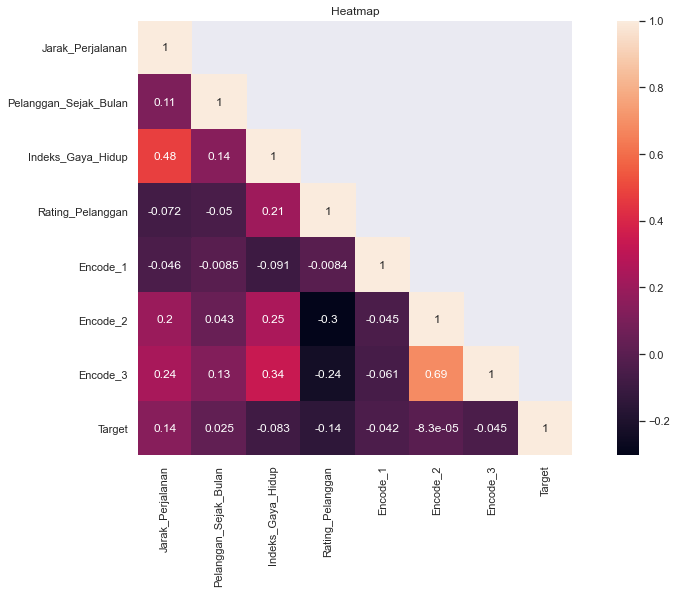

In [29]:
# Plot Data Correlations
fig, ax1 = plt.subplots(1, 1, figsize=(16,8))

#
mask = np.array(train.corr())
mask[np.tril_indices_from(mask)] = False


sns.heatmap(train.corr(), mask=mask, ax=ax1, annot=True, square=True)
ax1.set_title('Heatmap')

In [30]:
train['Tipe_Kendaraan'] = train['Tipe_Kendaraan'].apply(lambda x: x.upper() if type(x) == str else x)

DataError: No numeric types to aggregate

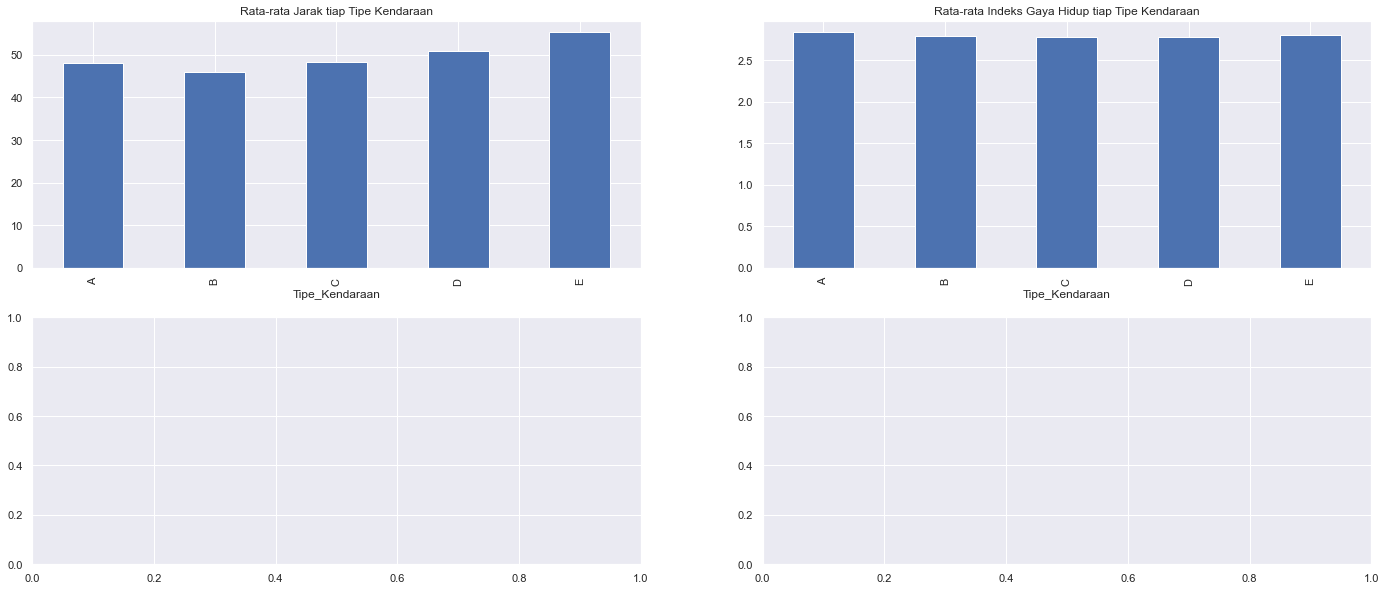

In [31]:
# Tipe Kendaraan Menjadi EDA
fig, ((ax1,ax2),(ax4,ax5)) = plt.subplots(2,2,figsize=(24,10))

train.groupby('Tipe_Kendaraan')['Jarak_Perjalanan'].mean().plot(ax=ax1, kind='bar', title='Rata-rata Jarak tiap Tipe Kendaraan')
train.groupby('Tipe_Kendaraan')['Indeks_Gaya_Hidup'].mean().plot(ax=ax2, kind='bar', title='Rata-rata Indeks Gaya Hidup tiap Tipe Kendaraan')

train.groupby('Tipe_Kendaraan')['Pembatalan_Sebulan_Terakhir'].mean().plot(ax=ax4, kind='bar', title='Rata-rata Pembatalan tiap Tipe Kendaraan')
train.groupby('Tipe_Kendaraan')['Rating_Pelanggan'].mean().plot(ax=ax5, kind='bar', title='Rata-rata Rating tiap Tipe Kendaraan')

ax1.tick_params(labelrotation=0)
ax2.tick_params(labelrotation=0)
ax3.tick_params(labelrotation=0)
ax4.tick_params(labelrotation=0)

<AxesSubplot:xlabel='Jarak_Perjalanan', ylabel='Indeks_Gaya_Hidup'>

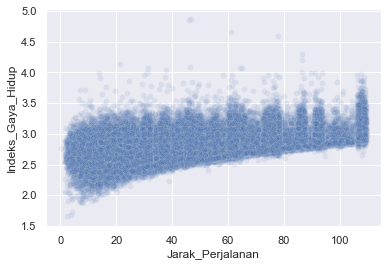

In [32]:
# Hubungan Rating Pelanggan dengan Pembatalan Sebulan Terakhir
sns.scatterplot(x='Jarak_Perjalanan', y='Indeks_Gaya_Hidup', data=train, alpha=0.1)

<AxesSubplot:xlabel='Jarak_Perjalanan', ylabel='Rating_Pelanggan'>

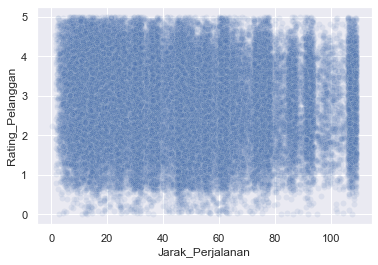

In [33]:
sns.scatterplot(x='Jarak_Perjalanan', y='Rating_Pelanggan', data=train[train['Rating_Pelanggan']<=5], alpha=0.1)

## Data Cleaning

### Drop rows with neg values

In [17]:
train_cleaned = train.copy()
test_cleaned = test.copy()

In [18]:
# train_cleaned['Pembatalan_Sebulan_Terakhir'] = train_cleaned['Pembatalan_Sebulan_Terakhir'].astype('float')

In [19]:
# drop negative
positive = train_cleaned['Pelanggan_Sejak_Bulan'].fillna(9999)>=0
train_cleaned = train_cleaned[positive]

In [20]:
train_cleaned.shape

(98710, 11)

In [21]:
# drop negative
positive = train_cleaned['Pembatalan_Sebulan_Terakhir'].fillna(9999)>=0
train_cleaned = train_cleaned[positive]

In [22]:
train_cleaned.shape

(98708, 11)

### add column: missing

In [23]:
train_cleaned['nan_per_row'] = train_cleaned.isna().sum(axis=1)
test_cleaned['nan_per_row'] = test_cleaned.isna().sum(axis=1)

In [24]:
train_cleaned['has_nan'] = train_cleaned['nan_per_row'].map(lambda x: 1 if x>0 else 0)
test_cleaned['has_nan'] = test_cleaned['nan_per_row'].map(lambda x: 1 if x>0 else 0)

### Impute v2 with flag

In [25]:
train_cleanedv2 = train_cleaned.copy()
test_cleanedv2 = test_cleaned.copy()

In [26]:
outliers = train_cleanedv2['Rating_Pelanggan']<=5
train_cleanedv2 = train_cleanedv2[outliers]

In [27]:
missing_cols = list(train_cleanedv2.columns)
missing_cols.remove('Target')

In [28]:
for col in missing_cols:
    train_cleanedv2[col] = train_cleanedv2[col].fillna(-100)
    test_cleanedv2[col] = test_cleanedv2[col].fillna(-100)

In [29]:
df_summary(test_cleanedv2)

,column,dtype,missing,missing%,unique,unique%
0,Jarak_Perjalanan,float64,0,0.0,8490,0.257929
1,Tipe_Kendaraan,object,0,0.0,11,0.000334
2,Pelanggan_Sejak_Bulan,float64,0,0.0,16,0.000486
3,Indeks_Gaya_Hidup,float64,0,0.0,21542,0.654454
4,Tipe_Tujuan,object,0,0.0,17,0.000516
5,Rating_Pelanggan,float64,0,0.0,3586,0.108944
6,Pembatalan_Sebulan_Terakhir,float64,0,0.0,9,0.000273
7,Encode_2,float64,0,0.0,43,0.001306
8,Encode_3,float64,0,0.0,86,0.002613
9,Gender,object,0,0.0,3,0.000091


In [41]:
train_cleanedv2.to_csv('train_cleanedv2.csv', index=False)
test_cleanedv2.to_csv('test_cleanedv2.csv', index=False)

### Impute with statistics

In [30]:
# impute numerical cols
med = train_cleaned['Jarak_Perjalanan'].median()
train_cleaned['Jarak_Perjalanan'] = train_cleaned['Jarak_Perjalanan'].fillna(med)
test_cleaned['Jarak_Perjalanan'] = test_cleaned['Jarak_Perjalanan'].fillna(med)

mean = train_cleaned['Indeks_Gaya_Hidup'].mean()
train_cleaned['Indeks_Gaya_Hidup'] = train_cleaned['Indeks_Gaya_Hidup'].fillna(mean)
test_cleaned['Indeks_Gaya_Hidup'] = test_cleaned['Indeks_Gaya_Hidup'].fillna(mean)

for col in ['Encode_2','Encode_3']:
    mean = train_cleaned[col].mean()
    train_cleaned[col] = train_cleaned[col].fillna(mean)
    test_cleaned[col] = test_cleaned[col].fillna(mean)
    

In [31]:
imputer = SimpleImputer(strategy='most_frequent')

train_cleaned['Tipe_Kendaraan'] = imputer.fit_transform(train_cleaned['Tipe_Kendaraan'].values.reshape(-1,1))
test_cleaned['Tipe_Kendaraan'] = imputer.transform(test_cleaned['Tipe_Kendaraan'].values.reshape(-1,1))

train_cleaned['Tipe_Tujuan'] = imputer.fit_transform(train_cleaned['Tipe_Tujuan'].values.reshape(-1,1))
test_cleaned['Tipe_Tujuan'] = imputer.transform(test_cleaned['Tipe_Tujuan'].values.reshape(-1,1))

train_cleaned['Gender'] = imputer.fit_transform(train_cleaned['Gender'].values.reshape(-1,1))
test_cleaned['Gender'] = imputer.transform(test_cleaned['Gender'].values.reshape(-1,1))


In [32]:
# mean then round
val = round(train_cleaned['Pelanggan_Sejak_Bulan'].mean())
train_cleaned['Pelanggan_Sejak_Bulan'] = train_cleaned['Pelanggan_Sejak_Bulan'].fillna(val)
test_cleaned['Pelanggan_Sejak_Bulan'] = test_cleaned['Pelanggan_Sejak_Bulan'].fillna(val)

val = round(train_cleaned['Pembatalan_Sebulan_Terakhir'].mean())
train_cleaned['Pembatalan_Sebulan_Terakhir'] = train_cleaned['Pembatalan_Sebulan_Terakhir'].fillna(val)
test_cleaned['Pembatalan_Sebulan_Terakhir'] = test_cleaned['Pembatalan_Sebulan_Terakhir'].fillna(val)

In [33]:
# q75 = np.quantile(train['Rating_Pelanggan'].dropna(),.75)
outliers = train_cleaned['Rating_Pelanggan']<=5
train_cleaned = train_cleaned[outliers]

med = train_cleaned['Rating_Pelanggan'].median()
train_cleaned['Rating_Pelanggan'] = train_cleaned['Rating_Pelanggan'].fillna(med)
test_cleaned['Rating_Pelanggan'] = test_cleaned['Rating_Pelanggan'].fillna(med)

In [46]:
df_summary(train_cleaned)

,column,dtype,missing,missing%,unique,unique%
0,Jarak_Perjalanan,float64,0,0.0,9832,0.127201
1,Tipe_Kendaraan,object,0,0.0,10,0.000129
2,Pelanggan_Sejak_Bulan,float64,0,0.0,11,0.000142
3,Indeks_Gaya_Hidup,float64,0,0.0,37733,0.488169
4,Tipe_Tujuan,object,0,0.0,16,0.000207
5,Rating_Pelanggan,float64,0,0.0,3853,0.049848
6,Pembatalan_Sebulan_Terakhir,float64,0,0.0,9,0.000116
7,Encode_2,float64,0,0.0,54,0.000699
8,Encode_3,float64,0,0.0,90,0.001164
9,Gender,object,0,0.0,2,0.000026


### Upper case tipe

In [34]:
train_cleaned['Tipe_Kendaraan'] = train_cleaned['Tipe_Kendaraan'].map(lambda x: x.upper())
test_cleaned['Tipe_Kendaraan'] = test_cleaned['Tipe_Kendaraan'].map(lambda x: x.upper())

### Binning Jarak

In [35]:
bins = [0,20,40,60,80,100,999]
train_cleaned['Jarak_Perjalanan_bin'] = pd.cut(train_cleaned['Jarak_Perjalanan'], bins=bins).astype('O')
test_cleaned['Jarak_Perjalanan_bin'] = pd.cut(test_cleaned['Jarak_Perjalanan'], bins=bins).astype('O')

In [49]:
train_cleaned.select_dtypes('object')

,Tipe_Kendaraan,Tipe_Tujuan,Gender,Jarak_Perjalanan_bin
1,C,A,Pria,"(60, 80]"
2,B,E,Pria,"(40, 60]"
3,A,A,Pria,"(20, 40]"
4,C,H,Wanita,"(20, 40]"
5,B,A,Wanita,"(20, 40]"
...,...,...,...,...
98739,A,A,Pria,"(40, 60]"
98740,D,B,Pria,"(60, 80]"
98741,D,A,Pria,"(0, 20]"
98743,C,A,Pria,"(80, 100]"


### Label Encode

In [36]:
# train.drop(columns=['ID'], inplace=True)
def labelenc(train, test):
    tr = train.copy()
    ts = test.copy()
    
    enc = LabelEncoder()
    cat_cols = tr.select_dtypes('object').columns
    
    for col in cat_cols:
        enc.fit(tr[col])
        tr[col] = enc.transform(tr[col])
        ts[col] = enc.transform(ts[col])
    
    return tr, ts

In [37]:
train_enc, test_enc = labelenc(train_cleaned, test_cleaned)

In [38]:
df_summary(train_enc)

,column,dtype,missing,missing%,unique,unique%
0,Jarak_Perjalanan,float64,0,0.0,9832,0.127201
1,Tipe_Kendaraan,int32,0,0.0,5,0.000065
2,Pelanggan_Sejak_Bulan,float64,0,0.0,11,0.000142
3,Indeks_Gaya_Hidup,float64,0,0.0,37733,0.488169
4,Tipe_Tujuan,int32,0,0.0,16,0.000207
5,Rating_Pelanggan,float64,0,0.0,3853,0.049848
6,Pembatalan_Sebulan_Terakhir,float64,0,0.0,9,0.000116
7,Encode_2,float64,0,0.0,54,0.000699
8,Encode_3,float64,0,0.0,90,0.001164
9,Gender,int32,0,0.0,2,0.000026


## Feature Engineering

In [39]:
train_enc['Rasio_Jarak_Dengan_Indeks'] = train_enc['Jarak_Perjalanan'] / train_enc['Indeks_Gaya_Hidup']

test_enc['Rasio_Jarak_Dengan_Indeks'] = test_enc['Jarak_Perjalanan'] / test_enc['Indeks_Gaya_Hidup']

# train_enc['Rasio_Jarak_Dengan_Rating'] = train_enc['Jarak_Perjalanan'] / train['Rating_Pelanggan']
# test_enc['Rasio_Jarak_Dengan_Rating'] = test_enc['Jarak_Perjalanan'] / test['Rating_Pelanggan']

In [40]:
train_enc.to_csv('train cleaned+preprocessed.csv', index=False)
test_enc.to_csv('test cleaned+preprocessed.csv', index=False)

## Modelling

In [52]:
tx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54106 entries, 7210 to 82515
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Jarak_Perjalanan             54106 non-null  float64
 1   Tipe_Kendaraan               54106 non-null  int32  
 2   Pelanggan_Sejak_Bulan        54106 non-null  float64
 3   Indeks_Gaya_Hidup            54106 non-null  float64
 4   Tipe_Tujuan                  54106 non-null  int32  
 5   Rating_Pelanggan             54106 non-null  float64
 6   Pembatalan_Sebulan_Terakhir  54106 non-null  float64
 7   Encode_2                     54106 non-null  float64
 8   Encode_3                     54106 non-null  float64
 9   Gender                       54106 non-null  int32  
 10  nan_per_row                  54106 non-null  int64  
 11  has_nan                      54106 non-null  int64  
 12  Rasio_Jarak_Dengan_Indeks    54106 non-null  float64
dtypes: float64(8)

In [41]:
tx, valx, ty, valy = train_test_split(train_enc.drop('Target', axis=1), train_enc['Target'],
                                      random_state=69,
                                      test_size=0.3)

In [79]:
xgb = XGBClassifier(objective='multi:softmax', random_state=69, 
                        n_estimators=300, num_class=3)

xgb.fit(tx,ty)
val_pred = xgb.predict(valx)
print("Classification report of XGBoost Model \n")
print(report(valy, val_pred,digits=5))
# xgb.fit(tx,ty)
# val_pred = xgb.predict(valx)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[20:03:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification report of XGBoost Model 

              precision    recall  f1-score   support

           1    0.71059   0.50790   0.59239      4810
           2    0.62114   0.78606   0.69393     10026
           3    0.67691   0.57237   0.62026      8353

    accuracy                        0.65139     23189
   macro avg    0.66954   0.62211   0.63553     23189
weighted avg    0.65978   0.65139   0.64633     23189



In [42]:
cat = CatBoostClassifier(iterations=300, cat_features=['Tipe_Kendaraan','Tipe_Tujuan','Gender','Jarak_Perjalanan_bin'],
                         random_state=69, auto_class_weights='SqrtBalanced', verbose=0, thread_count=-1)
cat.fit(tx,ty)
val_pred = cat.predict(valx)
print("Classification report of CatBoost model (SqrtBalanced) \n")
print(report(valy, val_pred,digits=5))

Classification report of CatBoost model (SqrtBalanced) 

              precision    recall  f1-score   support

           1    0.68722   0.54220   0.60616      4810
           2    0.62714   0.79433   0.70090     10026
           3    0.70366   0.56399   0.62613      8353

    accuracy                        0.65906     23189
   macro avg    0.67267   0.63351   0.64440     23189
weighted avg    0.66716   0.65906   0.65432     23189



In [83]:
et = ExtraTreesClassifier(n_estimators=300, class_weight='balanced', max_depth=10,
                         random_state=69)
et.fit(tx,ty)
val_pred = cat.predict(valx)
print("Classification report of Extra Tree model (SqrtBalanced) \n")
print(report(valy, val_pred,digits=5))

Classification report of Extra Tree model (SqrtBalanced) 

              precision    recall  f1-score   support

           1    0.68824   0.54158   0.60617      4810
           2    0.62567   0.79304   0.69948     10026
           3    0.70042   0.56147   0.62330      8353

    accuracy                        0.65747     23189
   macro avg    0.67144   0.63203   0.64298     23189
weighted avg    0.66557   0.65747   0.65268     23189



In [55]:
param_grid1 = {
    'max_depth':(6,8,10),
    'n_estimators':(200,300,400),
    'max_features':(0.6,0.8,1),
    'min_samples_leaf':(1,2,3),
}

In [63]:
rscv_rf = RandomizedSearchCV(forest_clf, param_grid1, cv=5, scoring='accuracy', random_state=2)
rscv_rf.fit(tx,ty)

In [57]:
param_grid2 = {
    'depth':(6,8,10),
    'iterations':(200,300,400),
    'learning_rate':(0.01,0.1,0.3)
}

In [64]:
rscv_cat = RandomizedSearchCV(cat, param_grid2, cv=5, scoring='accuracy', random_state=2)
rscv_cat.fit(tx,ty)

In [65]:
param_grid3 = {
    'max_depth':(6,8,10),
    'iterations':(200,300,400),
    'learning_rate':(0.01,0.1,0.3),
    'subsample':(0.6,0.8,1),
}

In [66]:
rscv_xgb = RandomizedSearchCV(xgb, param_grid3, cv=5, scoring='accuracy', random_state=2)
rscv_xgb.fit(tx,ty)

In [67]:
rscv_et = RandomizedSearchCV(xgb, param_grid1, cv=5, scoring='accuracy', random_state=2)
rscv_et.fit(tx,ty)

In [84]:
# voting
vc = VotingClassifier([('rf', rscv_rf.best_estimator_),
                       ('xgb', rscv_xgb.best_estimator_),
                       ('et',rscv_et.best_estimator_),
                       ('cat',rscv_cat.best_estimator_)], voting='soft')
vc.fit(tx,ty)
val_pred = vc.predict(valx)

print("Classification report of Voting Model \n")
print(classification_report(valy, val_pred, digits=5))

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[20:05:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification report of Voting Model 

              precision    recall  f1-score   support

           1    0.72762   0.50873   0.59880      4810
           2    0.61845   0.82934   0.70853     10026
           3    0.71023   0.54256   0.61518      8353

    accuracy                        0.65954     23189
   macro avg    0.68543   0.62688   0.64084     23189
weighted avg    0.67416   0.65954   0.65214     23189



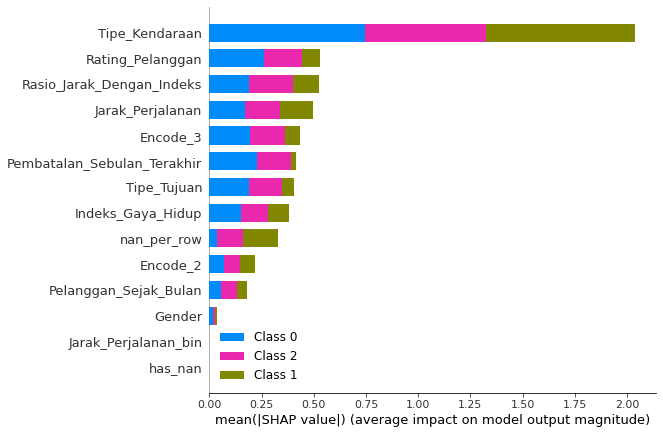

In [40]:
import shap
# Plotting feature importance with shap values on XGBoost model
fig = plt.figure()
explainer = shap.TreeExplainer(xgb)

# Calculate shap values
shap_values = explainer.shap_values(tx)
#plot shap values
shap.summary_plot(shap_values, tx)
# plt.savefig('shap.png')

In [599]:
samplesub = pd.read_csv('sampeSubmission.csv')
samplesub['Target'] = vc.predict(test_enc)
samplesub.to_csv('sub voting 4 clf.csv', index=False)